# VGG-19 Model

### Import required libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support, roc_curve, auc
import tensorflow as tf
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg19 import VGG19

### Define constants

In [ ]:
TRAIN_PATH = "/content/drive/MyDrive/Deep_Learning/Brain Tumor MRI Classification/Training"
TEST_PATH = "/content/drive/MyDrive/Deep_Learning/Brain Tumor MRI Classification/Testing"
IMAGE_SIZE = [224, 224]
BATCH_SIZE = 32
NUM_EPOCHS = 50

### Create data generators for training and validation with advanced data augmentation


In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2)

train_generator = train_datagen.flow_from_directory(
    TRAIN_PATH,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training')

validation_generator = train_datagen.flow_from_directory(
    TRAIN_PATH,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation')

test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    TEST_PATH,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical')

Found 2297 images belonging to 4 classes.
Found 573 images belonging to 4 classes.
Found 394 images belonging to 4 classes.


### Load the pre-trained VGG19 model without top layers

In [ ]:
base_model = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

80134624/80134624 [==============================] - 3s 0us/step


### Add new fully connected layers on top of the base model

In [ ]:
x = Flatten()(base_model.output)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
prediction = Dense(train_generator.num_classes, activation='softmax')(x)

### Create the model

In [ ]:
model = Model(inputs=base_model.input, outputs=prediction)

### Freeze all layers in the pre-trained model except the last four

In [ ]:
for layer in base_model.layers[:-4]:
    layer.trainable = False

### Model Summary

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

### Visualize the model architecture

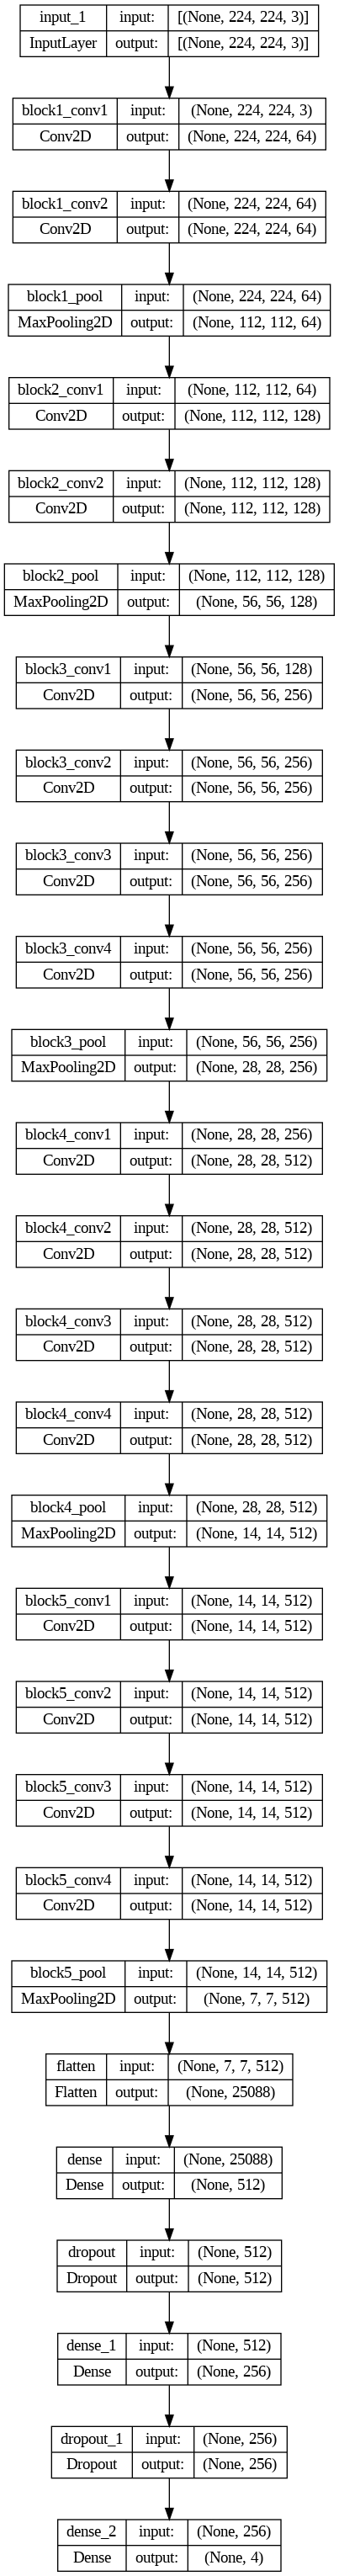

In [ ]:
plot_model(model=model, show_shapes=True)

### Implement Early Stopping to prevent overfitting

In [ ]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, mode='min',
                                              restore_best_weights=True)

### Compile the model with categorical cross-entropy loss and a lower learning rate


In [ ]:
model.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    metrics=['accuracy'])

### Train the model on training data and evaluate on validation data

In [ ]:
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=NUM_EPOCHS,
    steps_per_epoch=len(train_generator),
    validation_steps=len(validation_generator),
    callbacks=[early_stop])

Epoch 1/50
72/72 [==============================] - 973s 13s/step - loss: 1.2963 - accuracy: 0.4071 - val_loss: 1.0399 - val_accuracy: 0.5462
Epoch 2/50
72/72 [==============================] - 63s 874ms/step - loss: 0.8316 - accuracy: 0.6635 - val_loss: 0.8223 - val_accuracy: 0.6614
Epoch 3/50
72/72 [==============================] - 53s 742ms/step - loss: 0.6152 - accuracy: 0.7745 - val_loss: 0.6423 - val_accuracy: 0.7435
Epoch 4/50
72/72 [==============================] - 50s 701ms/step - loss: 0.5456 - accuracy: 0.8115 - val_loss: 0.6976 - val_accuracy: 0.7417
Epoch 5/50
72/72 [==============================] - 50s 696ms/step - loss: 0.4405 - accuracy: 0.8489 - val_loss: 0.6250 - val_accuracy: 0.7836
Epoch 6/50
72/72 [==============================] - 51s 715ms/step - loss: 0.3937 - accuracy: 0.8529 - val_loss: 0.5755 - val_accuracy: 0.7731
Epoch 7/50
72/72 [==============================] - 50s 699ms/step - loss: 0.3430 - accuracy: 0.8785 - val_loss: 0.5305 - val_accuracy: 0.7976


### Plot the training and validation accuracy

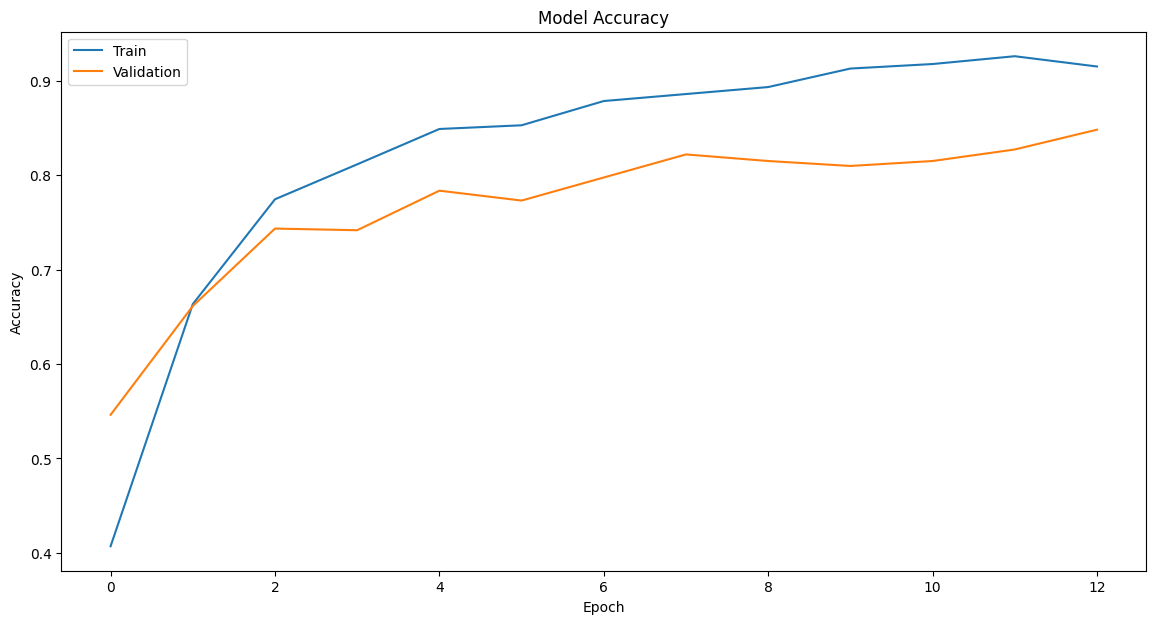

In [ ]:
fig, ax = plt.subplots(figsize=(14,7))
ax.plot(history.history['accuracy'])
ax.plot(history.history['val_accuracy'])
ax.set_title('Model Accuracy')
ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy')
ax.legend(['Train', 'Validation'], loc='upper left')
plt.show()

### Plot the Training and Validation Loss

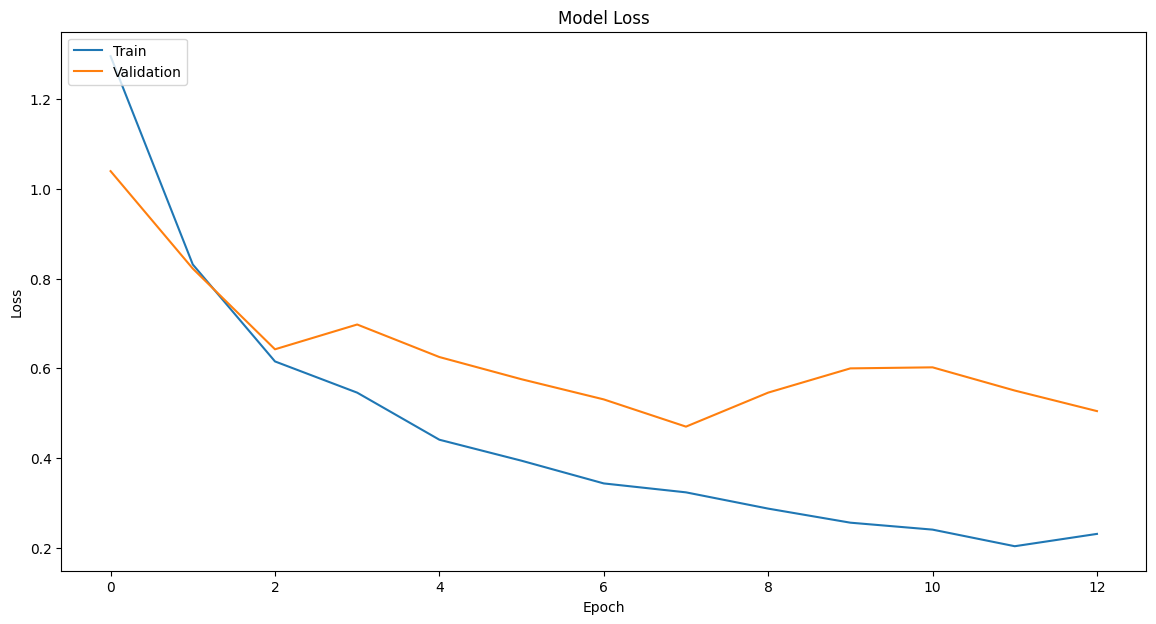

In [ ]:
fig, ax = plt.subplots(figsize=(14,7))
ax.plot(history.history['loss'])
ax.plot(history.history['val_loss'])
ax.set_title('Model Loss')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.legend(['Train', 'Validation'], loc='upper left')
plt.show()

### Test the model on the test data

In [ ]:
test_loss, test_acc = model.evaluate(test_generator, steps=len(test_generator))
print("Test accuracy:", test_acc)

13/13 [==============================] - 151s 13s/step - loss: 1.2287 - accuracy: 0.7132
Test accuracy: 0.7131979465484619


### Save the Model

In [ ]:
model.save('/content/drive/MyDrive/Deep_Learning/Brain Tumor MRI Classification/VGG_19.h5')

### Generate predictions on the test data

In [ ]:
y_pred = model.predict(test_generator, steps=len(test_generator))
y_true = test_generator.classes

13/13 [==============================] - 3s 198ms/step


### Generate and plot confusion matrix

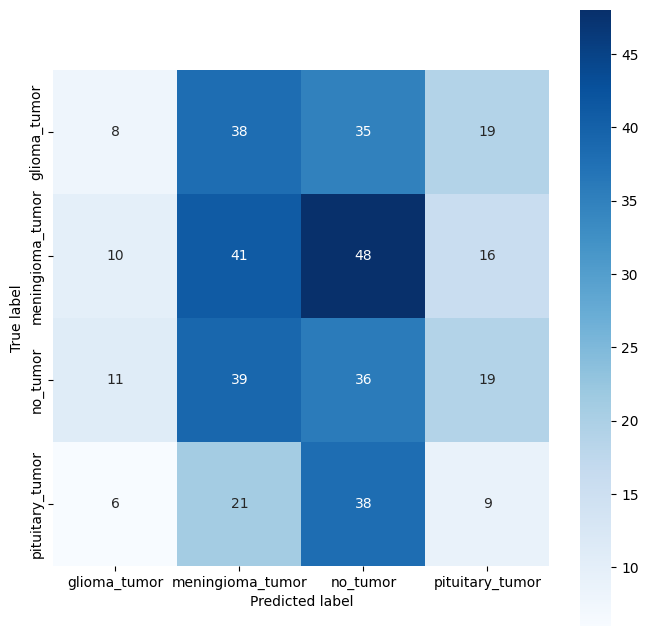

In [ ]:
cm = confusion_matrix(y_true, np.argmax(y_pred, axis=1))
plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, cmap="Blues", square=True, xticklabels=test_generator.class_indices.keys(),
            yticklabels=test_generator.class_indices.keys(), fmt='g')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

### Print classification report

In [ ]:
class_names = list(test_generator.class_indices.keys())
print(classification_report(y_true, np.argmax(y_pred, axis=1), target_names=class_names))

                  precision    recall  f1-score   support

    glioma_tumor       0.23      0.08      0.12       100
meningioma_tumor       0.29      0.36      0.32       115
        no_tumor       0.23      0.34      0.27       105
 pituitary_tumor       0.14      0.12      0.13        74

        accuracy                           0.24       394
       macro avg       0.22      0.23      0.21       394
    weighted avg       0.23      0.24      0.22       394



### Compute precision, recall, F1 score and support for each class


In [ ]:
precision, recall, f1_score, support = precision_recall_fscore_support(y_true, np.argmax(y_pred, axis=1))

### Create a dataframe with the computed metrics for each class

In [ ]:
metrics_df = pd.DataFrame({
    'Precision': precision,
    'Recall': recall,
    'F1 Score': f1_score,
    'Support': support
}, index=class_names)

### Print the dataframe


In [ ]:
print(metrics_df)

                  Precision    Recall  F1 Score  Support
glioma_tumor       0.228571  0.080000  0.118519      100
meningioma_tumor   0.294964  0.356522  0.322835      115
no_tumor           0.229299  0.342857  0.274809      105
pituitary_tumor    0.142857  0.121622  0.131387       74


### Compute ROC and AUC for each class

In [ ]:
fpr = {}
tpr = {}
roc_auc = {}

### Compute ROC and AUC for each class

In [ ]:
for i in range(train_generator.num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true == i, y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

### Plot ROC curve for each class

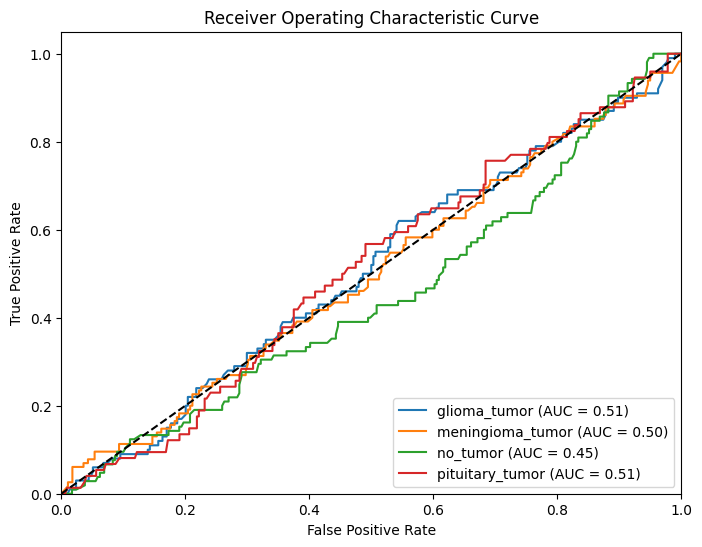

In [ ]:
plt.figure(figsize=(8, 6))
for i in range(train_generator.num_classes):
    plt.plot(fpr[i], tpr[i], label='%s (AUC = %0.2f)' % (class_names[i], roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Curve')
plt.legend(loc="lower right")
plt.show()